# Customer Segmentation - 101

In [1]:
import pandas as pd
import datetime as dt

In [2]:
# https://archive.ics.uci.edu/ml/datasets/online+retail
df = pd.read_excel("../data/cust_seg_101/Online Retail.xlsx")

In [3]:
customer_country=df[['Country','CustomerID']].drop_duplicates()
df= df[pd.notnull(df['CustomerID'])]
df = df[(df['Quantity']>0)]
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Recency calculation till the maximum date of the dataset (9/12/2011)
# NOW = dt.datetime.today
NOW = dt.datetime(2011,12,10)
print(df.head())

  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  TotalPrice  
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom       15.30  
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom       20.34  
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom       22.00  
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom       20.34  
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom       20.34  


- Recency value found by by subtracting that customer's maximum Invoice Date from NOW
- Frequency value found by counting the Invoice Number of that customer.
- Monetary value found by adding up all the totalprice of purchases of that Customer.

In [4]:
# RFM Score Logic
rfmTable = df.groupby('CustomerID').agg({'InvoiceDate': lambda x: (NOW - x.max()).days, 'InvoiceNo': lambda x: len(x), 'TotalPrice': lambda x: x.sum()})
rfmTable.rename(columns={'InvoiceDate': 'recency', 'InvoiceNo': 'frequency', 'TotalPrice': 'monetary_value'}, inplace=True)

# RFM Ranking Logic based on four quantiles
quantiles = rfmTable.quantile(q=[0.25,0.5,0.75])
quantiles = quantiles.to_dict()

rfm = rfmTable
print(rfm.head())

            recency  frequency  monetary_value
CustomerID                                    
12346.0         325          1        77183.60
12347.0           2        182         4310.00
12348.0          75         31         1797.24
12349.0          18         73         1757.55
12350.0         310         17          334.40


In [5]:
# The customer with the lowest recency value will be ranked 1, and greatest recency value will be ranked 4.
def RScore(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4
    
#R score calculation
rfm['r_quartile'] = rfm['recency'].apply(RScore, args=('recency', quantiles,))    

- Remember that difference between Rscore and FMScore is that in the former the lower quartile will be assigned 1 rank whereas in the latter greatest quartile will be assigned 1 rank.

In [6]:
# Frequency and Monetary value must be high enough for the customer to be ranked 1.
def FMScore(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1

rfm['f_quartile'] = rfm['frequency'].apply(FMScore, args=('frequency', quantiles,))
rfm['m_quartile'] = rfm['monetary_value'].apply(FMScore, args=('monetary_value', quantiles,))

In [7]:
# The customers with Recency 1 and Frequency 1 are the top customers who are considered as the potential to the marketing target.

rfm['RFMScore'] = rfm.r_quartile.map(str)+ rfm.f_quartile.map(str)+ rfm.m_quartile.map(str)
rfm[rfm['RFMScore']=='111'].sort_values('monetary_value', ascending=False).head(10)

,recency,frequency,monetary_value,r_quartile,f_quartile,m_quartile,RFMScore
CustomerID,,,,,,,
14646.0,1,2080,280206.02,1,1,1,111
18102.0,0,431,259657.30,1,1,1,111
17450.0,8,337,194550.79,1,1,1,111
14911.0,1,5677,143825.06,1,1,1,111
14156.0,9,1400,117379.63,1,1,1,111
17511.0,2,963,91062.38,1,1,1,111
16684.0,4,277,66653.56,1,1,1,111
14096.0,4,5111,65164.79,1,1,1,111
13694.0,3,568,65039.62,1,1,1,111


### Problem: A data mining company needs to segment their customers according to their income and spend ratio.

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; 

sns.set()  
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')

/Users/smithkakar/.conda/envs/ds/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/smithkakar/.conda/envs/ds/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'Income / spend')

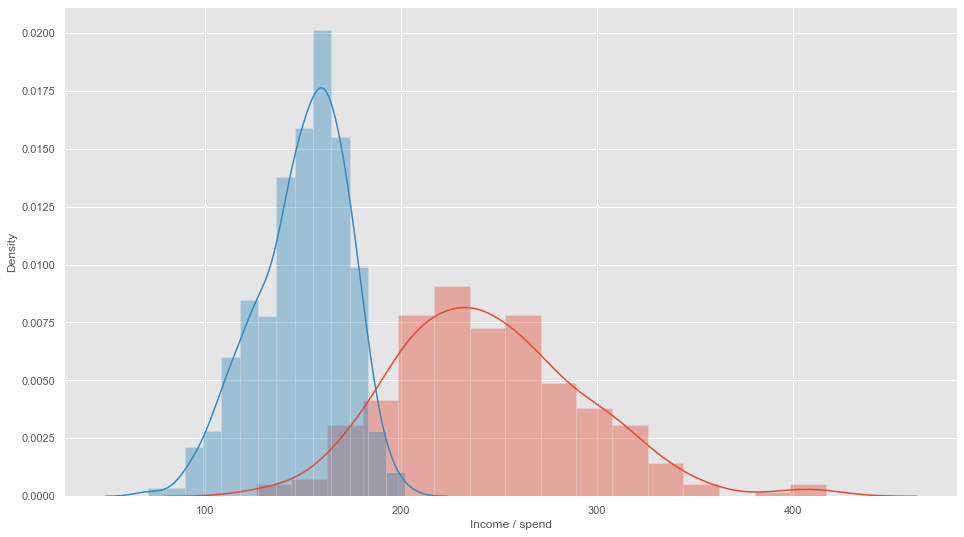

In [9]:
dataset = pd.read_csv('../data/cust_seg_101/CLV.csv')
# Visualising the data
plot_income = sns.distplot(dataset["INCOME"])
plot_spend = sns.distplot(dataset["SPEND"])
plt.xlabel('Income / spend')

In [10]:
X = dataset.iloc[:,[0,1]].values

In [11]:
# Elbow method
from sklearn.cluster import KMeans
wcss = []

for i in range(1,11):
    km=KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    km.fit(X)
    wcss.append(km.inertia_)

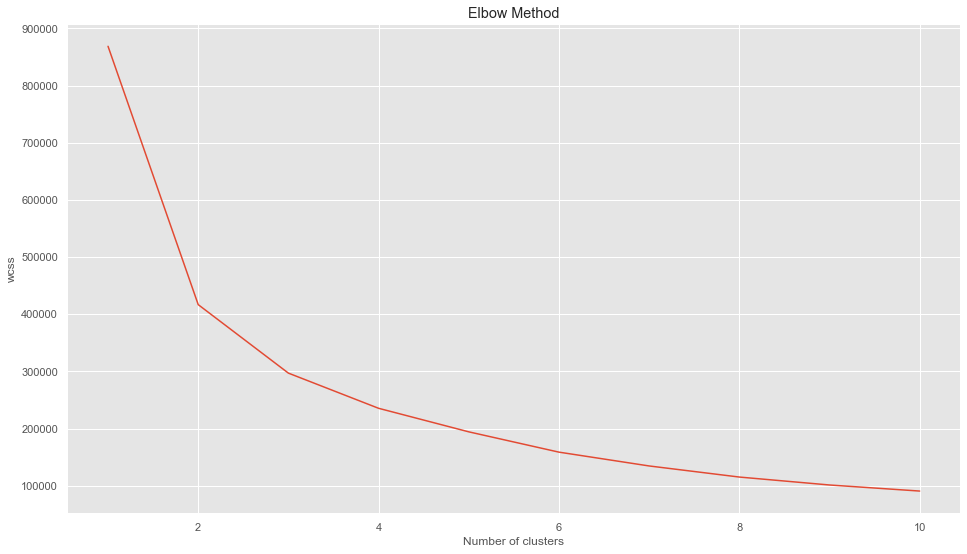

In [12]:
plt.plot(range(1,11),wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('wcss')
plt.show()

In [13]:
# Fitting kmeans to the dataset with K=4
km4 = KMeans(n_clusters=4, init='k-means++', max_iter=300, n_init=10, random_state=0)
y_means = km4.fit_predict(X)

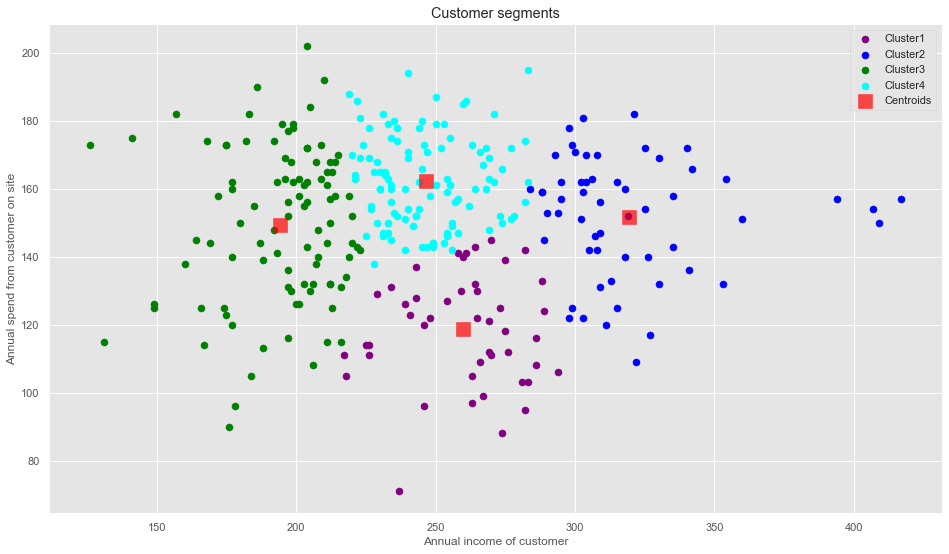

In [14]:
# Visualizing the clusters for k=4

plt.scatter(X[y_means==0,0],X[y_means==0,1],s=50, c='purple',label='Cluster1')
plt.scatter(X[y_means==1,0],X[y_means==1,1],s=50, c='blue',label='Cluster2')
plt.scatter(X[y_means==2,0],X[y_means==2,1],s=50, c='green',label='Cluster3')
plt.scatter(X[y_means==3,0],X[y_means==3,1],s=50, c='cyan',label='Cluster4')

plt.scatter(km4.cluster_centers_[:,0], km4.cluster_centers_[:,1], s=200, marker='s', c='red', alpha=0.7, label='Centroids')

plt.title('Customer segments')
plt.xlabel('Annual income of customer')
plt.ylabel('Annual spend from customer on site')
plt.legend()
plt.show()

In [ ]:
# Advanced concept 
wcss = []
distances = []
for i in range(0,10):
    p1 = Point(initx=1,inity=wcss[0])
    p2 = Point(initx=10,inity=wcss[9])
    p = Point(initx=i+1,inity=wcss[i])
    distances.append(p.distance_to_line(p1,p2))